In [1]:
import pandas as pd
import joblib
pd.set_option('max_colwidth', 500)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 9})
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from utils import *
import xgboost as xgb
%matplotlib notebook

%load_ext autoreload
%autoreload 2
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

# 0 - Problem Statement
The goal of this notebook is to show possible usage of Random Forest regressor for timeseries forecasting; in the notebook multiple example are given with the usage of a general purpose library.<br>
The notebook contains the following sections:

1. Introduction to univariate & multivariate timeseries datasets
2. Cross validation: two different techniques
3. CART regressor on univariate timeseries
4. CART on multivariate timeseries

# 1 - Introduction to univariate & multivariate timeseries datasets
A timeseries without covariates is an "univariate" timeseries.<br>
Here below an example of female births dataset, that is the monthly births across three years. <br>
Credits: <br>
https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv <br>
https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

<IPython.core.display.Javascript object>


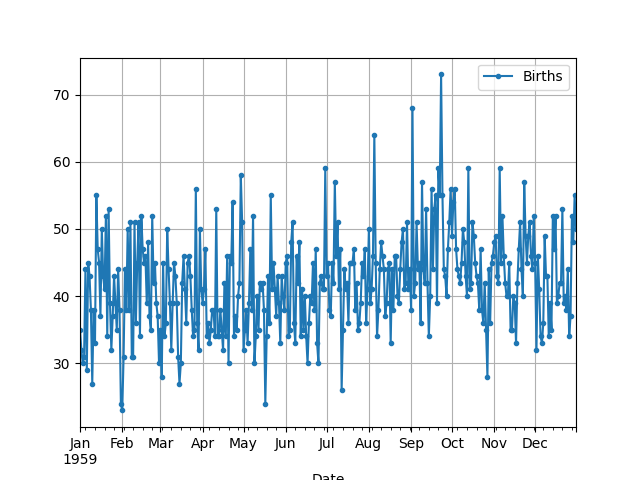

In [2]:
filename = 'daily-total-female-births.csv'
# load the dataset
series = pd.read_csv(filename, header=0, index_col=0, parse_dates=True)
values = series.values

# plot dataset
ax = series.plot(style='.-')
ax.grid()
plt.show(block=False)

A timeseries with covariates is a multivaraite timeseries.<br>
This dataset contains 19 different features such as air temperature, atmospheric pressure, and humidity collected from 2009 to 2016 with 1 records every hour.<br>
Credits: <br>https://www.bgc-jena.mpg.de/wetter/ <br>https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip <br>
https://www.tensorflow.org/tutorials/structured_data/time_series

<IPython.core.display.Javascript object>


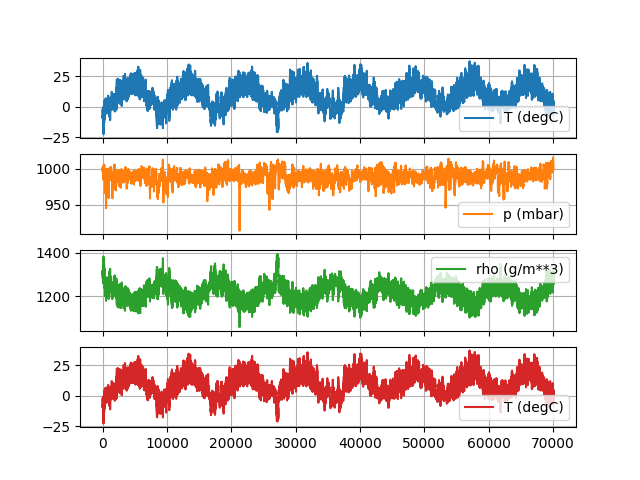

In [3]:
filename = 'weather_dataset.csv'
# load the dataset
data = pd.read_csv(filename, header=0, index_col=0, parse_dates=True)

# plot some features
feat = ['T (degC)', 'p (mbar)', 'rho (g/m**3)', 'T (degC)']
data.plot(y=feat,style='-',grid=True,subplots=True)
plt.show(block=False)

The models in this notebook will make a set of predictions on both datasets based on a window of consecutive samples. <br>

The main features of the input windows are:

- The width (number of time steps) of the input and label windows. (parameter "n_in")
- The time offset between them. (parameter "n_ahead")
- Single-time-step and multi-time-step predictions. (parameter "single_output")
- Single-output or multi-output predictions. (for multivariate only)

This notebook will use the function "series_to_supervised" to do the data windowing.<br>


<img src="figures/TS_exaplained_pw.png">

Here below an example of the usage of the "series_to_supervised" function.<br>
Timestamps till <b>t</b> are the training samples.

In [4]:
############## Params START ##############
n_in = 6 # Number of "previous data" to use as input
n_ahead = 4 # Number of step ahead to predict
single_output = False # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
single_feature = True # If True, use only last columns as output tag
n_out = 1 if single_output else n_ahead # Number of outputs of the model
filename = 'daily-total-female-births.csv'
############## Params End ##############

# load the dataset
series = pd.read_csv(filename, header=0, index_col=0)
values = series.values

# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=n_in, n_out=n_ahead, single_output=single_output,single_feature=single_feature)
data.head()

,var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4)
6,35.0,32.0,30.0,31.0,44.0,29.0,45,43.0,38.0,27.0,38.0
7,32.0,30.0,31.0,44.0,29.0,45.0,43,38.0,27.0,38.0,33.0
8,30.0,31.0,44.0,29.0,45.0,43.0,38,27.0,38.0,33.0,55.0
9,31.0,44.0,29.0,45.0,43.0,38.0,27,38.0,33.0,55.0,47.0
10,44.0,29.0,45.0,43.0,38.0,27.0,38,33.0,55.0,47.0,45.0


In [5]:
############## Params START ##############
n_in = 3 # Number of "previous data" to use as input
n_ahead = 2 # Number of step ahead to predict
single_output = True # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
single_feature = True # If True, use only last columns as output tag
n_out = 1 if single_output else n_ahead # Number of outputs of the model
filename = 'weather_dataset.csv'
############## Params End ##############

# load the dataset
df = pd.read_csv(filename, header=0, index_col=0)
df = df[['p (mbar)', 'rho (g/m**3)', 'T (degC)']]

# transform the time series data into supervised learning
data = series_to_supervised(df.values, n_in=n_in, n_out=n_ahead, single_output=single_output, single_feature=single_feature)
data.head()

,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t),var3(t+2)
3,996.50,1307.86,-8.05,996.62,1312.25,-8.88,996.84,1312.18,-8.81,996.99,1313.61,-9.05,-9.67
4,996.62,1312.25,-8.88,996.84,1312.18,-8.81,996.99,1313.61,-9.05,997.46,1317.19,-9.63,-9.17
5,996.84,1312.18,-8.81,996.99,1313.61,-9.05,997.46,1317.19,-9.63,997.71,1317.71,-9.67,-8.10
6,996.99,1313.61,-9.05,997.46,1317.19,-9.63,997.71,1317.71,-9.67,998.33,1315.98,-9.17,-7.66
7,997.46,1317.19,-9.63,997.71,1317.71,-9.67,998.33,1315.98,-9.17,999.17,1311.65,-8.10,-7.04


# 2 - Cross validation: two different techniques
The classical k-fold cross validation cannot be used for timeseries problems because the "shuffling" of the records can causa data leakage: information from the future will "leak" into the current prediction.<br>
For this reason, two different cross-validation techniques are applied:

- Sliding vs Expanding windows
- Walk forward cross validation

## 2.1 Sliding vs Examping window
The difference between sliding and expanding windows it is in the train dataset dimension: in the sliding window it is fixed, in the expanding window increases with the training. For both techniques the number of splits are specified by the user. <br>
Figures credits: https://www.analyticsvidhya.com/blog/2021/06/random-forest-for-time-series-forecasting/

<img src="figures/SlidingExpanding.png">

In this notebook only <b>expanding window</b> will be used since it uses most of the data for the training. <br>
Here below an example of the expanding window approach: <br>
Dataset credits: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

<IPython.core.display.Javascript object>


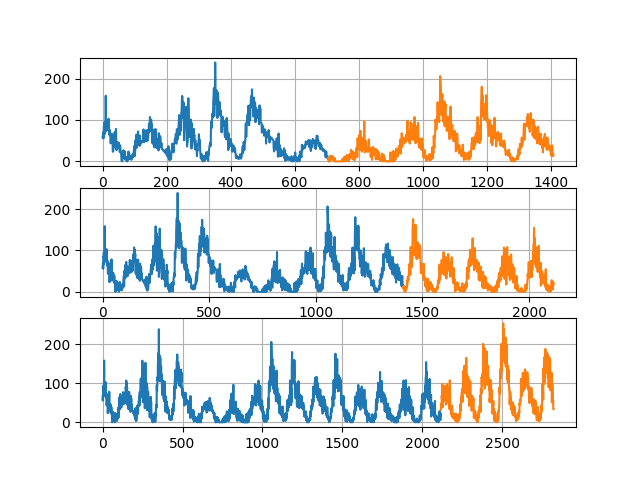

Observations: 1410
Training Observations: 705
Testing Observations: 705
Observations: 2115
Training Observations: 1410
Testing Observations: 705
Observations: 2820
Training Observations: 2115
Testing Observations: 705


In [6]:
series = pd.read_csv('sunspots.csv', header=0, index_col=0)
X = series.values
splits = TimeSeriesSplit(n_splits=3)
plt.figure()
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index][:,0]
    test = X[test_index][:,0]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(3,1,0 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    plt.grid()
    index += 1
plt.show()

## 2.2 Walk forawd cross validation
Walk forward cross validation is a particular case of expanding window where the dimension of the test set is of one record only, so the number of splits will be equal to the number of test sample used for cross validation (parameter "n_test" for function "walk_forward_validation").

<img src="figures/splits.png">

# 3 - CART regressor on univariate timeseries
The main goal of this notebook is to use CART (Classification And Regression Tree) methods for timeseries forecasting. <br>
In this section multiple example of usage are presented and, each time a new CART methodology is used, the main parameter are described.<br>

<b>NOTE:</b> Two naive models are used for performance comparison:
- The persistence model which simply predicts based on last seen record.
- The mean model which simply predicts the average of the training samples.

<b>NOTE:</b> the metric used to compare the model are the Mean Absolute Error (MAE) and the Root Mean Square Error (RMSE).

## 3.1 Univariate Analysis
In this section three differnt CART techniques will be described and applied to the univariate case. This case is trivial but it will be used as a reference case for each technique.

In [7]:
output_metrics = pd.DataFrame(data={'Persistence':[float('nan'),float('nan')],
                                    'Mean':[float('nan'),float('nan')],
                                    'DecisionTree':[float('nan'),float('nan')],
                                    'RandomForest':[float('nan'),float('nan')],
                                    'GradientBoosting':[float('nan'),float('nan')],
                                    'SuperLearner':[float('nan'),float('nan')]},index=['MAE','RMSE'])

### 3.1.1 - Decision Tree Regressor
The Decision Tree Regressor is the first CART used in this notebook. The main parameters of this CART are the following:
- "criterion": the greedy algorithm based on the CART training process, need a function to decide the best split. The criterion specifies which function to be used.
- "max_depth": maximum depth of the tree. This parameter controls the maximum depth of the tree to avoid overfitting.
- "min_samples_split": The minimum number of samples required to split a node.
- "min_samples_leaf": The minimum number of samples required to be at a leaf node.
- "ccp_alpha": The tree can be pruned after its growth. To prune the tree a cost associated to the complexity is added in the cost function of the trainig; this parameter regulates the cost associated to the complexity.

Here below there is example of decision tree usage on univariate timeseries (the female dataset births dataset).

In [8]:
############## Data Preprocessing Params ##############
n_in = 5 # Number of "previous data" to use as input
n_ahead = 1 # Number of step ahead to predict
single_output = True # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
single_feature = True # If True, use only last columns as output tag
n_out = 1 if single_output else n_ahead # Number of outputs of the model
train_size = 0.8 # Size of the training set
n_splits = 5 # Number of splits for cross validation
filename = 'daily-total-female-births.csv'
############## Data Preprocessing Params ##############

# load the dataset
series = pd.read_csv(filename, header=0, index_col=0)

# Transform the time series data into supervised learning
data = series_to_supervised(series.values, n_in=n_in, n_out=n_ahead, single_output=single_output)
data_train = data.values[0:int(train_size*data.shape[0])]
data_test = data.values[int(train_size*data.shape[0]):]
testX, testy = data_test[:, :-n_out], data_test[:, -n_out:]
                            
# Start the training process
predictions = list()
predictions_persistence = list()
predictions_mean = list()
y = list()
# Split dataset
ts_splits = TimeSeriesSplit(n_splits=n_splits)
# Step over each split
for train_index, val_index in ts_splits.split(data_train):
    train = data_train[train_index]
    val = data_train[val_index]
    
    # Split test row into input and output columns
    valX, valy = val[:, :-n_out], val[:, -n_out:]
    
    # transform list into array
    train = np.asarray(train)
    
    # split into input and output columns
    trainX, trainy = train[:, :-n_out], train[:, -n_out:]
    
    # fit model
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy.flatten())
    
    # Perform prediction
    yhat = model.predict(valX)
    
    # Use persistence & mean models
    predictions_persistence.append(valX[:,-1])
    predictions_mean.append(valX.mean(axis=1))
    
    # store forecast in list of predictions
    predictions.append(yhat.flatten())
    y.append(valy.flatten())

# Refit the model on the entire training dataset
model = DecisionTreeRegressor(random_state=0)
model.fit(data_train[:, :-n_out], data_train[:, -n_out:])

# Estimate prediction error
predictions = np.array(predictions).flatten()
predictions_persistence = np.array(predictions_persistence).flatten()
predictions_mean = np.array(predictions_mean).flatten()
y = np.array(y).flatten()
print('Decision Tree - training MAE = {:.3f}'.format(mean_absolute_error(y, predictions)))
print('Persistence - training MAE = {:.3f}'.format(mean_absolute_error(y, predictions_persistence)))
print('Mean - training MAE = {:.3f}'.format(mean_absolute_error(y, predictions_mean)))
# Evaluate regressor on test set
print('Decision Tree - test MAE = {:.3f}'.format(mean_absolute_error(testy, model.predict(testX))))
print('Persistence - test MAE = {:.3f}'.format(mean_absolute_error(testy, testX[:,-1])))
print('Mean - test MAE = {:.3f}'.format(mean_absolute_error(testy, testX.mean(axis=1))))
print('Decision Tree - test RMSE = {:.3f}'.format(rmse(testy, model.predict(testX))))
print('Persistence - test RMSE = {:.3f}'.format(rmse(testy, testX[:,-1])))
print('Mean - test RMSE = {:.3f}'.format(rmse(testy, testX.mean(axis=1))))
output_metrics.loc['MAE','Persistence'] = mean_absolute_error(testy, testX[:,-1])
output_metrics.loc['MAE','Mean'] = mean_absolute_error(testy, testX.mean(axis=1))
output_metrics.loc['RMSE','Persistence'] = rmse(testy, testX[:,-1])
output_metrics.loc['RMSE','Mean'] = rmse(testy, testX.mean(axis=1))

Decision Tree - training MAE = 8.766
Persistence - training MAE = 7.179
Mean - training MAE = 5.867
Decision Tree - test MAE = 7.319
Persistence - test MAE = 6.278
Mean - test MAE = 5.683
Decision Tree - test RMSE = 9.339
Persistence - test RMSE = 7.751
Mean - test RMSE = 6.808


The same training process can be done by using Scikit-learn package <b>GridSearchCV</b>.

In [9]:
gs = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), cv=ts_splits, param_grid={}, scoring='neg_mean_absolute_error')
gs.fit(data_train[:, :-n_out], data_train[:, -n_out:])
print('Decision Tree - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('Decision Tree - test MAE = {:.3f}'.format(mean_absolute_error(testy, gs.best_estimator_.predict(testX))))

Decision Tree - training MAE = 8.766
Decision Tree - test MAE = 7.319


The <b>GridSearchCV</b> can be also used for <b>hyper-parameters</b> tuning.

In [10]:
force_retraining = False
gs = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), cv=ts_splits, 
                  param_grid={
                      'criterion':['mae','mse'],
                      'max_depth':[3,10,100,300],
                      'min_samples_split': [5,10,100,1000],
                      'ccp_alpha': [0,0.0001,0.001,0.01,1]                      
                  },
                  scoring='neg_mean_absolute_error',
                  verbose = 0, n_jobs=-1)
if force_retraining:
    gs.fit(data_train[:, :-n_out], data_train[:, -n_out:])
    joblib.dump(gs, 'models/Univariate/DecisionTree.pkl')
else:
    gs = joblib.load('models/Univariate/DecisionTree.pkl')
print('Decision Tree - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('Decision Tree - test MAE = {:.3f}'.format(mean_absolute_error(testy, gs.best_estimator_.predict(testX))))
print('Decision Tree - test RMSE = {:.3f}'.format(rmse(testy, gs.best_estimator_.predict(testX))))
gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
gs_res.head(10)

Decision Tree - training MAE = 6.245
Decision Tree - test MAE = 5.500
Decision Tree - test RMSE = 6.917


,params,mean_test_score
98,"{'ccp_alpha': 0.01, 'criterion': 'mae', 'max_depth': 3, 'min_samples_split': 100}",-5.712766
66,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 3, 'min_samples_split': 100}",-5.712766
2,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 3, 'min_samples_split': 100}",-5.712766
34,"{'ccp_alpha': 0.0001, 'criterion': 'mae', 'max_depth': 3, 'min_samples_split': 100}",-5.712766
127,"{'ccp_alpha': 0.01, 'criterion': 'mse', 'max_depth': 300, 'min_samples_split': 1000}",-5.763129
27,"{'ccp_alpha': 0, 'criterion': 'mse', 'max_depth': 100, 'min_samples_split': 1000}",-5.763129
123,"{'ccp_alpha': 0.01, 'criterion': 'mse', 'max_depth': 100, 'min_samples_split': 1000}",-5.763129
63,"{'ccp_alpha': 0.0001, 'criterion': 'mse', 'max_depth': 300, 'min_samples_split': 1000}",-5.763129
115,"{'ccp_alpha': 0.01, 'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 1000}",-5.763129
31,"{'ccp_alpha': 0, 'criterion': 'mse', 'max_depth': 300, 'min_samples_split': 1000}",-5.763129


The best model of the above list is the number 2, since it is the "simplest" one among the group with best performances.

<IPython.core.display.Javascript object>


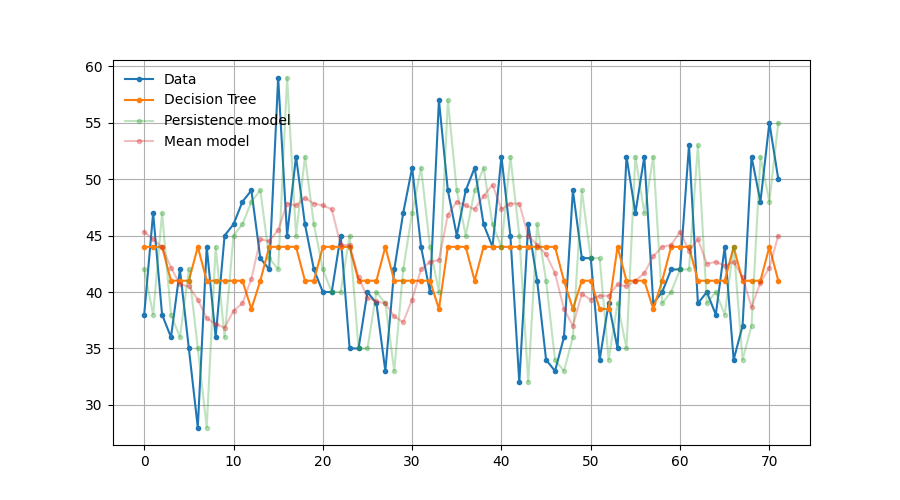

In [11]:
idx = 2
dt_tuned = DecisionTreeRegressor(random_state=0)
dt_tuned.set_params(**gs_res.loc[idx,'params'])
dt_tuned.fit(data_train[:, :-n_out], data_train[:, -n_out:])
yhat = dt_tuned.predict(testX)
def plot_univariate(yhat,label):
    plt.figure(figsize=(9,5))
    plt.plot(testy,'.-',label='Data')
    plt.plot(yhat,'.-',label=label)
    plt.plot(testX[:,-1],'.-',label='Persistence model', alpha=0.3)
    plt.plot(testX.mean(axis=1),'.-',label='Mean model',alpha=0.3)
    plt.legend(frameon=False, loc=0)
    plt.grid()
plot_univariate(yhat,label='Decision Tree')
output_metrics.loc['MAE','DecisionTree'] = mean_absolute_error(testy, dt_tuned.predict(testX))
output_metrics.loc['RMSE','DecisionTree'] = rmse(testy, dt_tuned.predict(testX))

### 3.1.2 - Random Forest Regressor
The Random Forest Regressor is the second CART used in this notebook. This method combines an ensemble of DecisionTree and weight their output to generate the prediction. This technique allows the applciation a bootstrap operation on the data and the usage of only a portion of the features for each tree; both these features have the goal to mitigate the overfitting. <br>The main parameters of this CART are the following:
- "n_estimator": number of estimator to be trained by the algorithm.
- "criterion": the greedy algorithm based on the CART training process, need a function to decide the best split. The criterion specifies which function to be used.
- "max_depth": maximum depth of the tree. This parameter controls the maximum depth of the tree to avoid overfitting.
- "min_samples_split": The minimum number of samples required to split a node.
- "min_samples_leaf": The minimum number of samples required to be at a leaf node.
- "ccp_alpha": The tree can be pruned after its growth. To prune the tree a cost associated to the complexity is added in the cost function of the trainig; this parameter regulates the cost associated to the complexity.
- "bootstrap": if True, bootstrap procedure will be applied (always set to True in these examples)
- "max_features": The number of features to consider when looking for the best split. 

In [12]:
force_retraining = False
gs = GridSearchCV(estimator=RandomForestRegressor(random_state=0), cv=ts_splits,
                  param_grid={
                      'n_estimators': [10, 100, 1000],
                      'criterion':['mae'],
                      'max_depth':[10,100],
                      'min_samples_split': [5, 10, 100, 500],
                      'ccp_alpha': [0,0.001]
                  },
                  scoring='neg_mean_absolute_error',
                  verbose=10, n_jobs=-1)
if force_retraining:
    gs.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
    joblib.dump(gs, 'models/Univariate/RandomForest.pkl')
else:
    gs = joblib.load('models/Univariate/RandomForest.pkl')
print('Random Forest - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('Random Forest - test MAE = {:.3f}'.format(mean_absolute_error(testy, gs.best_estimator_.predict(testX))))
gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
gs_res.head(10)

Random Forest - training MAE = 6.053
Random Forest - test MAE = 5.306


,params,mean_test_score
18,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 100, 'n_estimators': 10}",-5.814681
42,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 100, 'n_estimators': 10}",-5.814681
6,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 10, 'min_samples_split': 100, 'n_estimators': 10}",-5.814681
30,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 10, 'min_samples_split': 100, 'n_estimators': 10}",-5.814681
22,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 100}",-5.858149
34,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 10, 'min_samples_split': 500, 'n_estimators': 100}",-5.858149
46,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 100}",-5.858149
10,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 10, 'min_samples_split': 500, 'n_estimators': 100}",-5.858149
45,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 10}",-5.859574
21,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 10}",-5.859574


The best model of the above list is the number 18, since it is the "simplest" one among the group with best performances.

<IPython.core.display.Javascript object>


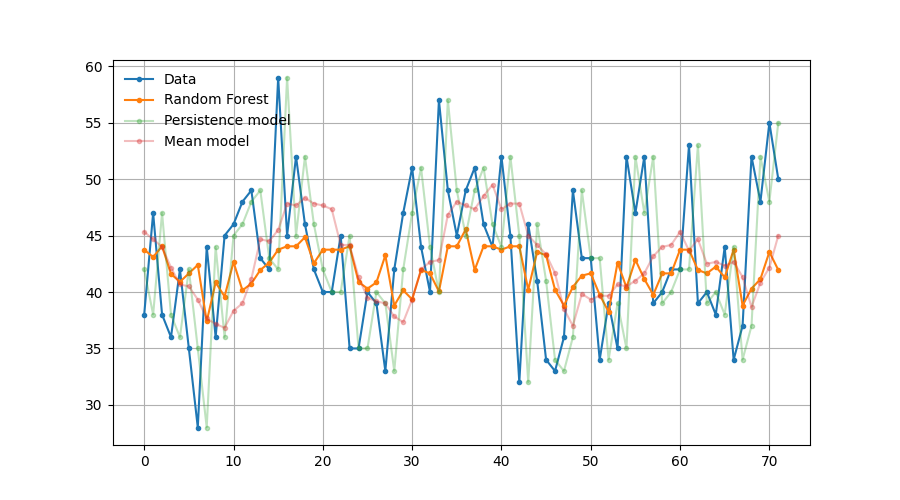

In [13]:
idx = 18
rf_tuned = RandomForestRegressor(random_state=0, n_jobs=-1)
rf_tuned.set_params(**gs_res.loc[idx,'params'])
rf_tuned.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
yhat = rf_tuned.predict(testX)
plot_univariate(yhat,label='Random Forest')
output_metrics.loc['MAE','RandomForest'] = mean_absolute_error(testy, rf_tuned.predict(testX))
output_metrics.loc['RMSE','RandomForest'] = rmse(testy, rf_tuned.predict(testX))

### 3.1.3 Gradient Boosting Regressor

The Gradient Boosting Regressor is the third CART used in this notebook. This technique builds an additive model and it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.<br> The main parameters of this CART are the following:
- "loss": the loss function to be optimized.
- "learning_rate": the learning rate multiplier for each additional tree.
- "subsample": the fraction of samples to be used for fitting the individual base learners. 
- "n_estimator": number of estimator to be trained by the algorithm.
- "criterion": the greedy algorithm based on the CART training process, need a function to decide the best split. The criterion specifies which function to be used.
- "max_depth": maximum depth of the tree. This parameter controls the maximum depth of the tree to avoid overfitting.
- "min_samples_split": The minimum number of samples required to split a node.
- "min_samples_leaf": The minimum number of samples required to be at a leaf node.
- "ccp_alpha": The tree can be pruned after its growth. To prune the tree a cost associated to the complexity is added in the cost function of the trainig; this parameter regulates the cost associated to the complexity.
- "bootstrap": if True, bootstrap procedure will be applied (always set to True in these examples)
- "max_features": The number of features to consider when looking for the best split.
- "validation_fraction" and "n_iter_no_change" and "tol": Parameters for the early stopping criterion (use validation dataset to evaluate the loss and if it does not decrease stop the training).

In [14]:
force_retraining = False
gs = GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),cv=ts_splits,
                  param_grid={
                      'loss': ['ls','lad'],
                      'n_estimators': [10, 100, 1000],
                      'criterion':['mse'],
                      'max_depth':[5,10,100],
                      'min_samples_split': [5, 10, 30],
                      'learning_rate': [0.000001, 0.0001, 0.01, 0.1]
                  },
                  scoring='neg_mean_absolute_error',
                  verbose=10,n_jobs=-1)
if force_retraining:
    gs.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
    joblib.dump(gs, 'models/Univariate/GradientBoosting.pkl')
else:
    gs = joblib.load('models/Univariate/GradientBoosting.pkl')
print('Gradient Boosting - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('Gradient Boosting - test MAE = {:.3f}'.format(mean_absolute_error(testy, gs.best_estimator_.predict(testX))))
gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
gs_res.head(10)

Gradient Boosting - training MAE = 5.763
Gradient Boosting - test MAE = 5.340


,params,mean_test_score
9,"{'criterion': 'mse', 'learning_rate': 1e-06, 'loss': 'ls', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 10}",-5.763131
12,"{'criterion': 'mse', 'learning_rate': 1e-06, 'loss': 'ls', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 10}",-5.763132
0,"{'criterion': 'mse', 'learning_rate': 1e-06, 'loss': 'ls', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}",-5.763132
3,"{'criterion': 'mse', 'learning_rate': 1e-06, 'loss': 'ls', 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 10}",-5.763133
18,"{'criterion': 'mse', 'learning_rate': 1e-06, 'loss': 'ls', 'max_depth': 100, 'min_samples_split': 5, 'n_estimators': 10}",-5.763133
24,"{'criterion': 'mse', 'learning_rate': 1e-06, 'loss': 'ls', 'max_depth': 100, 'min_samples_split': 30, 'n_estimators': 10}",-5.763134
15,"{'criterion': 'mse', 'learning_rate': 1e-06, 'loss': 'ls', 'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 10}",-5.763134
21,"{'criterion': 'mse', 'learning_rate': 1e-06, 'loss': 'ls', 'max_depth': 100, 'min_samples_split': 10, 'n_estimators': 10}",-5.763134
6,"{'criterion': 'mse', 'learning_rate': 1e-06, 'loss': 'ls', 'max_depth': 5, 'min_samples_split': 30, 'n_estimators': 10}",-5.763134
10,"{'criterion': 'mse', 'learning_rate': 1e-06, 'loss': 'ls', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}",-5.763146


<IPython.core.display.Javascript object>


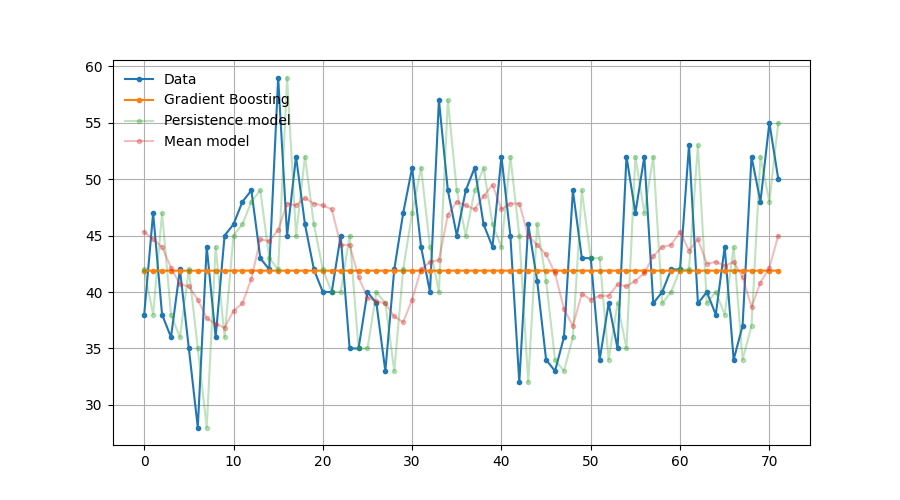

In [15]:
idx = 9
gb_tuned = GradientBoostingRegressor(random_state=0)
gb_tuned.set_params(**gs_res.loc[idx,'params'])
gb_tuned.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
yhat = gb_tuned.predict(testX)
plot_univariate(yhat,label='Gradient Boosting')
output_metrics.loc['MAE','GradientBoosting'] = mean_absolute_error(testy, gb_tuned.predict(testX))
output_metrics.loc['RMSE','GradientBoosting'] = rmse(testy, gb_tuned.predict(testX))

Very detailed hyper-parameter tuning has been performed on Gradient Boosting algorithm but without success. This CART predicts always a fixed value so suffers of <b>high bias</b> and <b>low variance</b>.

### 3.1.4 SuperLearner
The idea behind the SuperLearner is to <b>combine different regressors</b> and average all the outputs to obtain predicted values. This type of regressor can be useful for a set of well performing models in order to balance out their individual weaknesses. <br>
It has been decided to use the following regressors:

- Decision Tree
- Random Forest
- Linear Regression

The Gradient Boosting algorithm was not sued because of its poor performances.<br>
Another interesting technique is the <b>stacked generalization</b>. This methodology uses a set of models in parallel (SuperLearner) and the output is used as input for a final estimator. This technique is out of scope of this notebook.


<IPython.core.display.Javascript object>


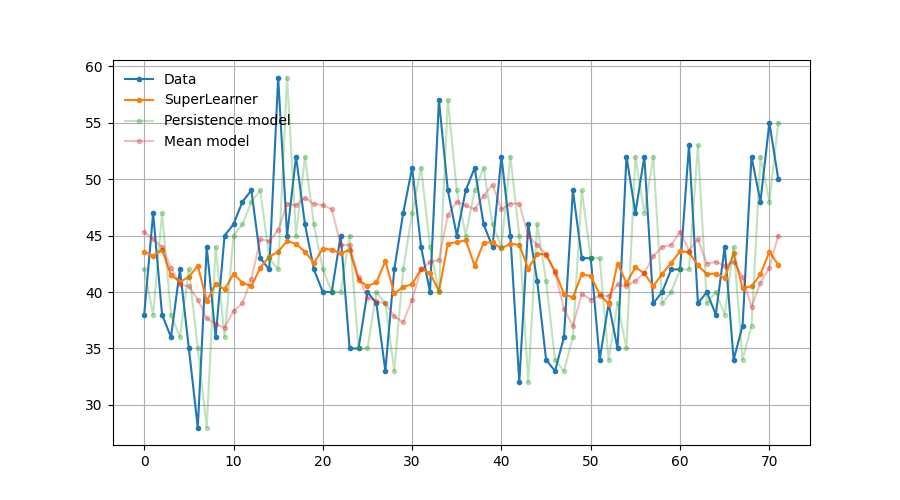

In [16]:
force_retraining = False
reg1 = dt_tuned
reg2 = rf_tuned
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('dt', reg1), ('rf', reg2), ('lr', reg3)])
if force_retraining:
    ereg = ereg.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
    joblib.dump(ereg, 'models/Univariate/SuperLearner.pkl')
else:
    ereg = joblib.load('models/Univariate/SuperLearner.pkl')

yhat = ereg.predict(testX)
plot_univariate(yhat,label='SuperLearner')
output_metrics.loc['MAE','SuperLearner'] = mean_absolute_error(testy, ereg.predict(testX))
output_metrics.loc['RMSE','SuperLearner'] = rmse(testy, ereg.predict(testX))

Finally, the performances of all models are compared together on the <b>entire set</b> (training and test). <br>

<IPython.core.display.Javascript object>


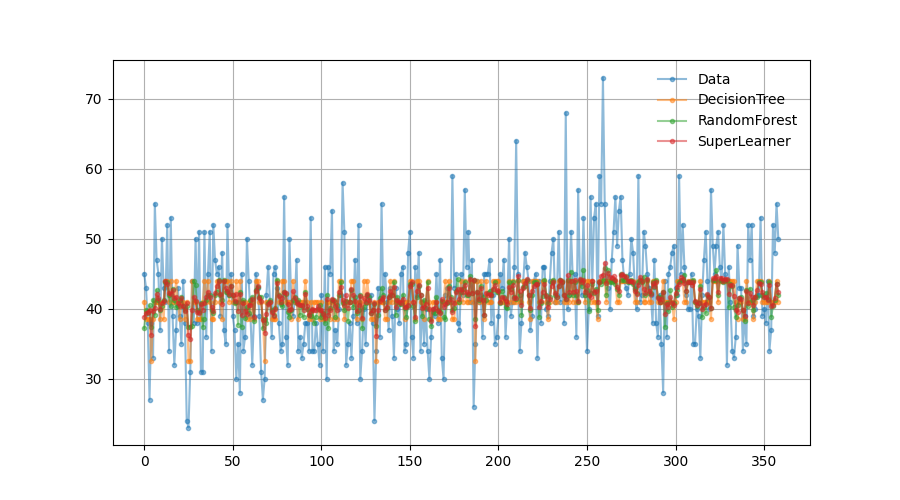

,Persistence,Mean,DecisionTree,RandomForest,GradientBoosting,SuperLearner
MAE,6.277778,5.682870,5.500000,5.305556,5.340441,5.261214
RMSE,7.751344,6.808361,6.916667,6.682933,6.568058,6.597304


In [17]:
plt.figure(figsize=(9,5))
plt.plot(data.values[:,-n_out:],'.-',label='Data', alpha = 0.5)
plt.plot(dt_tuned.predict(data.values[:,:-n_out]),'.-',label='DecisionTree', alpha = 0.5)
plt.plot(rf_tuned.predict(data.values[:,:-n_out]),'.-',label='RandomForest', alpha =0.5)
plt.plot(ereg.predict(data.values[:,:-n_out]),'.-',label='SuperLearner', alpha = 0.5)
plt.legend(frameon=False, loc=0)
plt.grid()
output_metrics

### 3.2 Data Preprocessing Params Tuning
All the regressor shown in the 3.1 sections have the data preprocessing parameter fixed.<br>
In this section different "n_in" (number of "lags") values will be used to generate the prediction.

In [18]:
force_retraining = False
############## Data Preprocessing Params ##############
n_in_list = [2,5,11,23] # Number of "previous data" to use as input
n_ahead = 1 # Number of step ahead to predict
single_output = True # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
single_feature = True # If True, use only last columns as output tag
n_out = 1 if single_output else n_ahead # Number of outputs of the model
train_size = 0.8 # Size of the training set
n_splits = 3 # Number of splits for cross validation
filename = 'daily-total-female-births.csv'
############## Data Preprocessing Params ##############

output_metrics_preproc = pd.DataFrame(data={'Persistence - 3':[float('nan'),float('nan')]},index=['MAE','RMSE'])

for n_in in n_in_list:
    print('Testing {}'.format(n_in))
    # load the dataset
    series = pd.read_csv(filename, header=0, index_col=0)

    # Transform the time series data into supervised learning
    data = series_to_supervised(series.values, n_in=n_in, n_out=n_ahead, single_output=single_output)
    data_train = data.values[0:int(train_size*data.shape[0])]
    data_test = data.values[int(train_size*data.shape[0]):]
    testX, testy = data_test[:, :-n_out], data_test[:, -n_out:]
    
    # Naive regressors
    output_metrics_preproc.loc['MAE','Persistence - {}'.format(n_in)] = mean_absolute_error(testy, testX[:,-1])
    output_metrics_preproc.loc['RMSE', 'Persistence - {}'.format(n_in)] = rmse(testy, testX[:,-1])
    output_metrics_preproc.loc['MAE','Mean - {}'.format(n_in)] = mean_absolute_error(testy, testX.mean(axis=1))
    output_metrics_preproc.loc['RMSE','Mean - {}'.format(n_in)] = rmse(testy, testX.mean(axis=1))
    
    # Decision Tree
    gs_dt = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), cv=ts_splits, 
                  param_grid={'criterion':['mae','mse'],
                              'max_depth':[3,10,100,300],
                              'min_samples_split': [5,10,100,1000],
                              'ccp_alpha': [0,0.0001,0.001,0.01,1]
                             },
                  scoring='neg_mean_absolute_error',
                  verbose = 0, n_jobs=-1)
    if force_retraining:
        gs_dt.fit(data_train[:, :-n_out], data_train[:, -n_out:])
        joblib.dump(gs_dt, 'models/Univariate/n_in_tuning/DecisionTree_nin_{}.pkl'.format(n_in))
    else:
        gs_dt = joblib.load('models/Univariate/n_in_tuning/DecisionTree_nin_{}.pkl'.format(n_in))
    print('DecisionTree on {} tuned!'.format(n_in))    
    yhat = gs_dt.best_estimator_.predict(testX)
    output_metrics_preproc.loc['MAE','Decision Tree - {}'.format(n_in)] = mean_absolute_error(testy, yhat)
    output_metrics_preproc.loc['RMSE','Decision Tree - {}'.format(n_in)] = rmse(testy, yhat)
    
    # Random Forest
    gs_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=0), cv=ts_splits,
                  param_grid={
                      'n_estimators': [10, 100, 1000],
                      'criterion':['mae'],
                      'max_depth':[10,100],
                      'min_samples_split': [5, 10, 100, 500],
                      'ccp_alpha': [0,0.001]
                  },
                  scoring='neg_mean_absolute_error',
                  verbose=0, n_jobs=-1)
    
    if force_retraining:
        gs_rf.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
        joblib.dump(gs_rf, 'models/Univariate/n_in_tuning/RandomForest_nin_{}.pkl'.format(n_in))
    else:
        gs_rf = joblib.load('models/Univariate/n_in_tuning/RandomForest_nin_{}.pkl'.format(n_in))
    print('RandomForest on {} tuned!'.format(n_in))    
    yhat = gs_rf.best_estimator_.predict(testX)
    output_metrics_preproc.loc['MAE','Random Forest - {}'.format(n_in)] = mean_absolute_error(testy, yhat)
    output_metrics_preproc.loc['RMSE','Random Forest - {}'.format(n_in)] = rmse(testy, yhat)
    
    # Gradient Boosting
    gs_gb = GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),cv=ts_splits,
                  param_grid={
                      'loss': ['ls','lad'],
                      'n_estimators': [10, 100, 1000],
                      'criterion':['mse'],
                      'max_depth':[5,10,100],
                      'min_samples_split': [5, 10, 30],
                      'learning_rate': [0.000001, 0.01]
                  },
                  scoring='neg_mean_absolute_error',
                  verbose=0,n_jobs=-1)
    if force_retraining:
        gs_gb.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
        joblib.dump(gs_gb, 'models/Univariate/n_in_tuning/GradientBoosting_nin_{}.pkl'.format(n_in))
    else:
        gs_gb = joblib.load('models/Univariate/n_in_tuning/GradientBoosting_nin_{}.pkl'.format(n_in))
    print('GradientBoosting on {} tuned!'.format(n_in))   
    yhat = gs_gb.best_estimator_.predict(testX)
    output_metrics_preproc.loc['MAE','Gradient Boosting - {}'.format(n_in)] = mean_absolute_error(testy, yhat)
    output_metrics_preproc.loc['RMSE','Gradient Boosting - {}'.format(n_in)] = rmse(testy, yhat)
    
    # Super Learner
    reg1 = gs_dt.best_estimator_
    reg2 = gs_rf.best_estimator_
    reg3 = LinearRegression()
    ereg = VotingRegressor(estimators=[('dt', reg1), ('rf', reg2), ('lr', reg3)])
    if force_retraining:
        ereg = ereg.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
        joblib.dump(ereg, 'models/Univariate/n_in_tuning/SuperLearner_nin_{}.pkl'.format(n_in))
    else:
        ereg = joblib.load('models/Univariate/n_in_tuning/SuperLearner_nin_{}.pkl'.format(n_in))
    print('SuperLearner on {} tuned!'.format(n_in)) 
    yhat = ereg.predict(testX)
    output_metrics_preproc.loc['MAE','SuperLearner - {}'.format(n_in)] = mean_absolute_error(testy, yhat)
    output_metrics_preproc.loc['RMSE','SuperLearner - {}'.format(n_in)] = rmse(testy, yhat) 
    

Testing 2
DecisionTree on 2 tuned!
RandomForest on 2 tuned!
GradientBoosting on 2 tuned!
SuperLearner on 2 tuned!
Testing 5
DecisionTree on 5 tuned!
RandomForest on 5 tuned!
GradientBoosting on 5 tuned!
SuperLearner on 5 tuned!
Testing 11
DecisionTree on 11 tuned!
RandomForest on 11 tuned!
GradientBoosting on 11 tuned!
SuperLearner on 11 tuned!
Testing 23
DecisionTree on 23 tuned!
RandomForest on 23 tuned!
GradientBoosting on 23 tuned!
SuperLearner on 23 tuned!


In [19]:
output_metrics_preproc.T.sort_values(by=['MAE','RMSE'])

,MAE,RMSE
Decision Tree - 23,5.072992,6.403410
SuperLearner - 2,5.109161,6.371582
Decision Tree - 2,5.153992,6.442686
SuperLearner - 23,5.191362,6.550392
Gradient Boosting - 2,5.246571,6.504997
SuperLearner - 5,5.261214,6.597304
Random Forest - 5,5.305556,6.682933
Gradient Boosting - 5,5.340441,6.568058
Random Forest - 2,5.355479,6.609464
Mean - 23,5.374396,6.704167


<IPython.core.display.Javascript object>


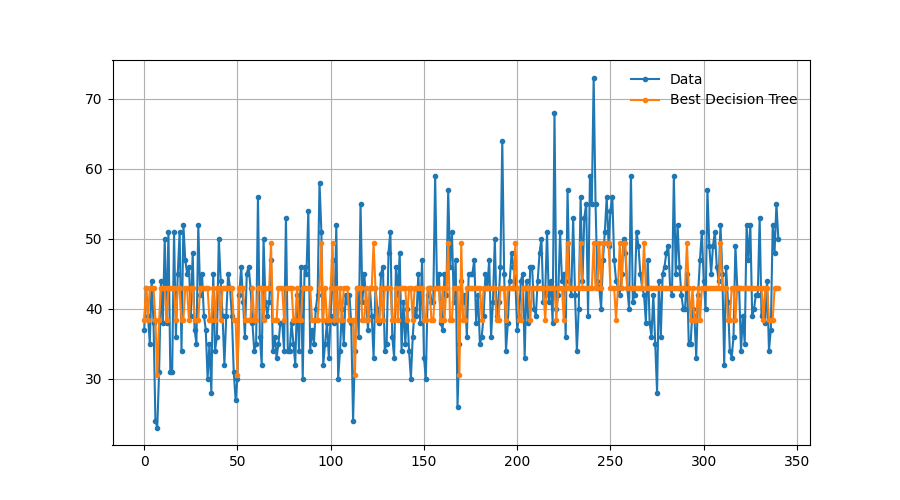

In [20]:
gs_dt = joblib.load('models/Univariate/n_in_tuning/DecisionTree_nin_23.pkl')
yhat = gs_dt.best_estimator_.predict(data.values[:,:-n_out])
plt.figure(figsize=(9,5))
plt.plot(data.values[:,-n_out:],'.-',label='Data')
plt.plot(yhat,'.-',label='Best Decision Tree')
plt.legend(frameon=False, loc=0)
plt.grid()

# 4 - Multivariate Analysis
This section will show the usage of CART models on a multivariate dataset. <br>
This dataset contains 19 different features such as air temperature, atmospheric pressure, and humidity collected from 2009 to 2016 with 1 records every hour. A complete <b>dataset analysis and feature engineering</b> can be found in the TensorFlow credits; for the sake of brevity, it will not be reported here. <br>
The goal is to <b>predict the air temperature</b> based on multiple features. Particularly interesting is the feature engineering on daily and yearly dependence:

- Two continuous variables (sine and cosine) will represent the time of the day and the time of the year. The usage of sine and cosine ensures unique values for both timings.


Credits: <br>https://www.bgc-jena.mpg.de/wetter/ <br>https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip <br>
https://www.tensorflow.org/tutorials/structured_data/time_series



<IPython.core.display.Javascript object>


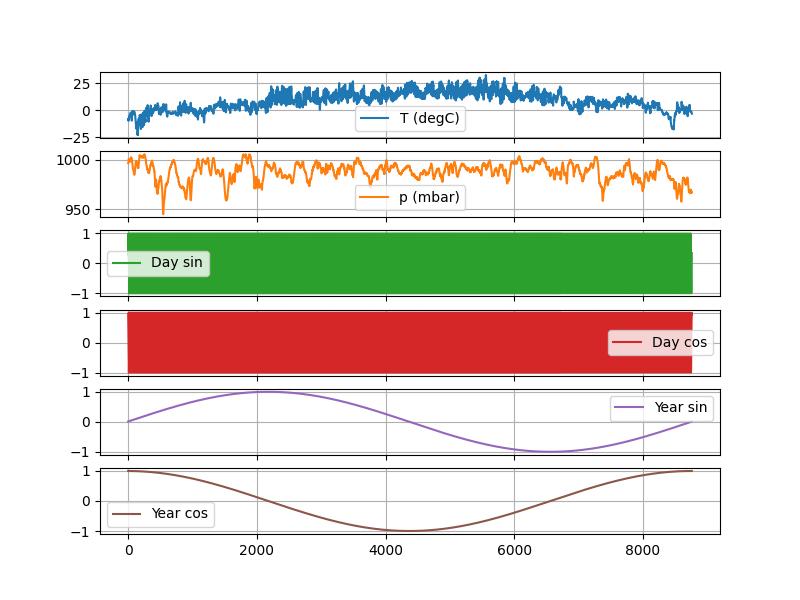

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
1,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
2,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
3,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
4,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


In [21]:
filename = 'weather_dataset.csv'
# load the dataset
df = pd.read_csv(filename, header=0, index_col=0, parse_dates=True)

# plot some features
feat = ['T (degC)','p (mbar)','Day sin', 'Day cos', 'Year sin','Year cos']
df.iloc[0:8761].plot(y=feat,style='-',grid=True,subplots=True, figsize=(8,6))
plt.show(block=False)
df.head()

<b>NOTE:</b> Before building any model, two naive models and a linear regression model are defined for performance comparison:
- The persistence model which simply predicts based on last seen record.
- The mean model which simply predicts the average of the training samples.
- Linear model: y = beta*X + alpha

<b>NOTE:</b> The dataset has been normalize with a standard scaler (subtract the mean and divide by the standard deviation). CART models do not need the scaling since the splits are calculated one feature at a time but in the next section Lasso regression will be used and it requires (or at least is good practice) to perform the scaling.

In [22]:
############## Data Preprocessing Params ##############
n_in = 11 # Number of "previous data" to use as input
n_ahead = 6 # Number of step ahead to predict
single_output = True # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
single_feature = True # If True, use only last columns as output tag
n_out = 1 if single_output else n_ahead # Number of outputs of the model
train_size = 0.7 # Size of the training set
n_splits = 5 # Number of splits for cross validation
features_tag = ['Day sin', 'Day cos', 'Year sin','Year cos','p (mbar)']
target_tag = 'T (degC)'
filename = 'weather_dataset.csv'
############## Data Preprocessing Params ##############

output_multi_metrics = pd.DataFrame(data={'Persistence':[float('nan'),float('nan')],
                                    'Mean':[float('nan'),float('nan')],
                                    'Linear':[float('nan'),float('nan')],
                                    'Lasso':[float('nan'),float('nan')],
                                    'DecisionTree':[float('nan'),float('nan')],
                                    'RandomForest':[float('nan'),float('nan')],
                                    'XGBoost':[float('nan'),float('nan')],
                                    'SuperLearner':[float('nan'),float('nan')]},index=['MAE','RMSE'])

# load the dataset
df = pd.read_csv(filename, header=0, index_col=0)

# Divide into training and test
train_size = int(train_size*df.shape[0])
df_train = df[features_tag].iloc[0:train_size]
df_test = df[features_tag].iloc[train_size:]

# Scale the data
train_mean, train_std = df_train.mean(), df_train.std()
df_train_normed = (df_train - train_mean) / train_std
df_test_normed = (df_test - train_mean) / train_std

df_train_normed[target_tag] = df.iloc[0:train_size][target_tag].values
df_test_normed[target_tag] = df.iloc[train_size:][target_tag].values

# Transform the time series data into supervised learning
data_train = series_to_supervised(df_train_normed.values, n_in=n_in, n_out=n_ahead, 
                                  single_output=True, 
                                  single_feature=True)
X_train, y_train = data_train.values[:,:-1], data_train.values[:,-1]
data_test = series_to_supervised(df_test_normed.values, n_in=n_in, n_out=n_ahead, 
                                 single_output=single_output,
                                 single_feature=single_feature)
X_test, y_test = data_test.values[:, :-1], data_test.values[:, -1]

print('Training data size: {}'.format(X_train.shape))
print('Test data size: {}'.format(X_test.shape))


Training data size: (49046, 72)
Test data size: (21011, 72)


### Important note:
The dimension of the dataset is <b>massive</b> so the training process is very slow; to mitigate this problem, it has been decided to use just 2 years of data for the training process. Another possible solution could have been to resample the data (for example: 1 point every 6 hours) but the goal (in this notebook) is to predict the temeprature 1 hour ahead.

In [23]:
train_size = 2*365*24 # number of hours in 2 years
# Divide into training and test
df_train = df[features_tag].iloc[0:train_size]
df_test = df[features_tag].iloc[train_size:]

# Scale the data
train_mean, train_std = df_train.mean(), df_train.std()
df_train_normed = (df_train - train_mean) / train_std
df_test_normed = (df_test - train_mean) / train_std

df_train_normed[target_tag] = df.iloc[0:train_size][target_tag].values
df_test_normed[target_tag] = df.iloc[train_size:][target_tag].values

# Transform the time series data into supervised learning
data_train = series_to_supervised(df_train_normed.values, n_in=n_in, n_out=n_ahead,
                                  single_output=single_output,
                                  single_feature=single_feature)
X_train, y_train = data_train.values[:,:-1], data_train.values[:,-1]
data_test = series_to_supervised(df_test_normed.values, n_in=n_in, n_out=n_ahead,
                                 single_output=single_output,
                                 single_feature=single_feature)
X_test, y_test = data_test.values[:, :-1], data_test.values[:, -1]

print('Training data size: {}'.format(X_train.shape))
print('Test data size: {}'.format(X_test.shape))
data_train.head()

Training data size: (17503, 72)
Test data size: (52554, 72)


,var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),var6(t-11),var1(t-10),var2(t-10),var3(t-10),var4(t-10),...,var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var6(t+6)
11,0.366028,1.365930,0.014144,1.419353,1.069608,-8.05,0.707101,1.224654,0.015157,1.419343,...,1.419215,1.582275,-7.41,0.000011,-1.414214,0.025290,1.419197,1.515406,-6.87,-5.25
12,0.707101,1.224654,0.015157,1.419343,1.083686,-8.88,0.999988,0.999917,0.016171,1.419331,...,1.419197,1.515406,-6.87,-0.366006,-1.366027,0.026303,1.419179,1.483731,-5.89,-5.11
13,0.999988,0.999917,0.016171,1.419331,1.109495,-8.81,1.224728,0.707034,0.017184,1.419319,...,1.419179,1.483731,-5.89,-0.707080,-1.224752,0.027316,1.419159,1.457921,-5.94,-4.90
14,1.224728,0.707034,0.017184,1.419319,1.127092,-9.05,1.366005,0.365964,0.018197,1.419307,...,1.419159,1.457921,-5.94,-0.999966,-1.000014,0.028329,1.419139,1.466133,-5.69,-4.80
15,1.366005,0.365964,0.018197,1.419307,1.182231,-9.63,1.414192,-0.000049,0.019210,1.419293,...,1.419139,1.466133,-5.69,-1.224706,-0.707131,0.029342,1.419119,1.473172,-5.40,-4.50


As stated before, let's inspect the performances of 3 different techniques that will be used as a reference for performance.

<IPython.core.display.Javascript object>


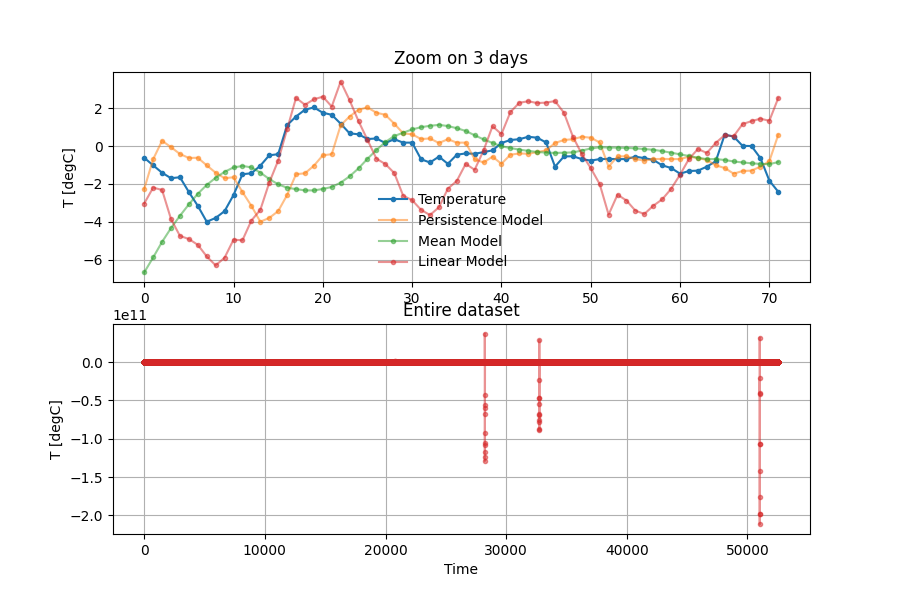

Persistence - test MAE = 3.235
Mean - test MAE = 3.768
Linear - test MAE = 54999379.847
Persistence - test RMSE = 4.289
Mean - test RMSE = 4.841
Linear - test RMSE = 2542472629.646


In [24]:
data_test_target_only = series_to_supervised(df_test_normed[[target_tag]].values, n_in=n_in, n_out=n_ahead, 
                                             single_output=single_output, single_feature=single_feature)
X_target_only, y_target_only = data_test_target_only.values[:, :-1], data_test_target_only.values[:, -1]

y_pers =  X_target_only[:,-1]
y_mean =  X_target_only.mean(axis=1)
reg = LinearRegression().fit(X_train, y_train)
y_lin = reg.predict(X_test)

n_days = 3

f, ax = plt.subplots(2,1,sharex=False, figsize=(9,6))
ax[0].plot(y_test[0:24*n_days],'.-',label='Temperature')
ax[0].plot(y_pers[0:24*n_days],'.-',label='Persistence Model', alpha = 0.5)
ax[0].plot(y_mean[0:24*n_days],'.-',label='Mean Model', alpha = 0.5)
ax[0].plot(y_lin[0:24*n_days], '.-',label='Linear Model', alpha = 0.5)
ax[0].set_title('Zoom on {} days'.format(n_days))
ax[0].legend(frameon=False)
ax[1].plot(y_test,'.-',label='Temperature')
ax[1].plot(y_pers,'.-',label='Persistence Model', alpha = 0.5)
ax[1].plot(y_mean,'.-',label='Mean Model', alpha = 0.5)
ax[1].plot(y_lin, '.-',label='Linear Model', alpha = 0.5)
ax[1].set_title('Entire dataset')
ax[0].set_ylabel('T [degC]')
ax[1].set_ylabel('T [degC]')
ax[1].set_xlabel('Time')
for a in ax: a.grid(True);

print('Persistence - test MAE = {:.3f}'.format(mean_absolute_error(y_test, y_pers)))
print('Mean - test MAE = {:.3f}'.format(mean_absolute_error(y_test, y_mean)))
print('Linear - test MAE = {:.3f}'.format(mean_absolute_error(y_test, y_lin)))
print('Persistence - test RMSE = {:.3f}'.format(rmse(y_test, y_pers)))
print('Mean - test RMSE = {:.3f}'.format(rmse(y_test, y_mean)))
print('Linear - test RMSE = {:.3f}'.format(rmse(y_test, y_lin)))
output_multi_metrics.loc['MAE','Persistence'] = mean_absolute_error(y_test, y_pers)
output_multi_metrics.loc['MAE','Mean'] = mean_absolute_error(y_test, y_mean)
output_multi_metrics.loc['MAE','Linear'] = mean_absolute_error(y_test, y_lin)
output_multi_metrics.loc['RMSE','Persistence'] = rmse(y_test, y_pers)
output_multi_metrics.loc['RMSE','Mean'] = rmse(y_test, y_mean)
output_multi_metrics.loc['RMSE','Linear'] = rmse(y_test, y_lin)

<b>NOTE:</b> it is clear from the very high MAE and RMSE (and from second subplots too) that linear regression is having a very unstable behavior in some areas.<br>
Let's inspect the coefficients of the regression.

In [25]:
reg.coef_

array([ 1.40151050e+10, -1.22829063e+10, -1.09545490e+10,  7.49489858e+11,
       -3.80717421e+00,  4.39920038e-01,  6.58785574e+09,  9.76078271e+06,
       -5.37022728e+08, -4.49030156e+07,  1.79874571e+00, -5.49876690e-02,
        3.32379717e+09,  4.02879395e+09,  3.84681872e+09, -2.99977351e+11,
        1.38163877e+00, -2.32892036e-02,  5.01102280e+09,  8.20142841e+09,
       -1.93209150e+10,  1.29983920e+12,  1.83700013e+00, -1.99558735e-02,
        2.86507091e+09,  6.39928817e+09, -8.84132782e+09,  5.19045488e+11,
        1.05605507e+00,  4.81891632e-03,  3.75515132e+09,  4.65338770e+09,
       -9.19448990e+09,  5.17731135e+11,  1.20855713e+00, -1.29394531e-02,
        1.23244000e+09,  6.74017473e+09, -6.69735902e+09,  3.21469302e+11,
        6.61651611e-01, -2.10571289e-02, -2.35038104e+09,  8.23279333e+09,
       -1.80643977e+09, -2.89382654e+10, -3.54843140e-01, -7.08007812e-03,
       -4.39007719e+09,  8.92063852e+09, -4.49702789e+09,  1.56565581e+11,
       -2.52685547e+00, -

It is evident that some coefficients have very high values; since just daily and yearly dependece is considered in this notebook, these coefficients have no reason to be so high.<br>
To mitigate this problem, let's apply the <b>Lasso</b> regularization technique and let's compare the coefficients.

<IPython.core.display.Javascript object>


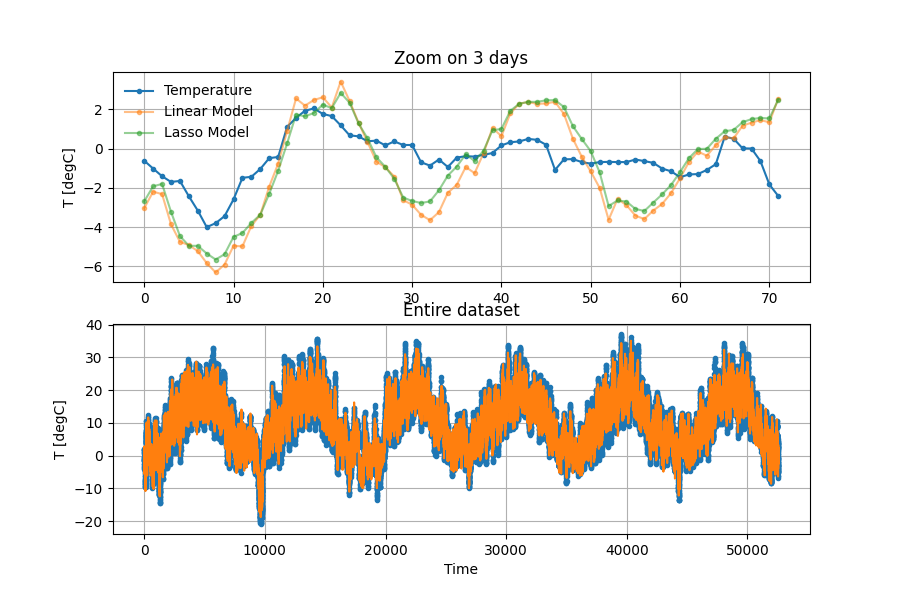

,Linear coeff,Lasso coeff
21,1.299839e+12,-0.000000
3,7.494899e+11,-0.503731
69,5.481040e+11,-0.000000
27,5.190455e+11,-0.000000
33,5.177311e+11,-0.000000
39,3.214693e+11,-0.000000
51,1.565656e+11,-0.000000
62,3.021212e+10,-0.000000
56,2.162032e+10,-0.000000
0,1.401511e+10,-0.000000


In [26]:
reg_lasso = Lasso(alpha=0.1, max_iter=2000).fit(X_train, y_train)
y_lasso = reg_lasso.predict(X_test)
output_multi_metrics.loc['MAE','Lasso'] = mean_absolute_error(y_test, y_lasso)
output_multi_metrics.loc['RMSE','Lasso'] = rmse(y_test, y_lasso)

n_days = 3

f, ax = plt.subplots(2,1,sharex=False, figsize=(9,6))
ax[0].plot(y_test[0:24*n_days],'.-',label='Temperature')
ax[0].plot(y_lin[0:24*n_days], '.-',label='Linear Model', alpha = 0.5)
ax[0].plot(y_lasso[0:24*n_days], '.-',label='Lasso Model', alpha = 0.5)
ax[0].set_title('Zoom on {} days'.format(n_days))
ax[0].legend(frameon=False)
ax[1].plot(y_test,'.-',label='Temperature')
# ax[1].plot(y_lin, '.-',label='Linear Model', alpha = 0.5)
ax[1].plot(y_lasso,label='Lasso Model')
ax[1].set_title('Entire dataset')
ax[0].set_ylabel('T [degC]')
ax[1].set_ylabel('T [degC]')
ax[1].set_xlabel('Time')
for a in ax: a.grid(True);

c = pd.DataFrame(data={'Linear coeff': reg.coef_,'Lasso coeff':reg_lasso.coef_}).sort_values(by='Linear coeff', ascending=False)
c.head(20)

In [27]:
output_multi_metrics

,Persistence,Mean,Linear,Lasso,DecisionTree,RandomForest,XGBoost,SuperLearner
MAE,3.234641,3.768481,5.499938e+07,1.984893,NaN,NaN,NaN,NaN
RMSE,4.289273,4.840742,2.542473e+09,2.566998,NaN,NaN,NaN,NaN


## 4.1 Multivariate Analysis

### 4.1.1 Decision Tree
As done for the univariate case, a Decision Tree with hyper-parameter tuning has been trained.

In [28]:
force_retraining = False
gs = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), cv=TimeSeriesSplit(n_splits=n_splits), 
                  param_grid={
                      'criterion':['mae'],
                      'max_depth':[5,50,300, 1000],
                      'min_samples_split': [10, 100],
                      'ccp_alpha': [0,0.001, 0.1, 1]        
                  },
                  scoring='neg_mean_absolute_error',
                  refit=True,
                  verbose = 10, n_jobs=-1)
if force_retraining:
    gs.fit(X_train, y_train)
    joblib.dump(gs, 'models/Multivariate/DecisionTree.pkl')
else:
    gs = joblib.load('models/Multivariate/DecisionTree.pkl')
print('Decision Tree - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('Decision Tree - test MAE = {:.3f}'.format(mean_absolute_error(y_test, gs.best_estimator_.predict(X_test))))
print('Decision Tree - test RMSE = {:.3f}'.format(rmse(y_test, gs.best_estimator_.predict(X_test))))
gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
gs_res.head(10)

Decision Tree - training MAE = 3.131
Decision Tree - test MAE = 2.034
Decision Tree - test RMSE = 2.694


,params,mean_test_score
15,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 1000, 'min_samples_split': 100}",-3.035368
13,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 300, 'min_samples_split': 100}",-3.035368
11,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 50, 'min_samples_split': 100}",-3.035368
3,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 50, 'min_samples_split': 100}",-3.043627
5,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 300, 'min_samples_split': 100}",-3.043627
7,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 1000, 'min_samples_split': 100}",-3.043627
8,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 5, 'min_samples_split': 10}",-3.130617
0,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 5, 'min_samples_split': 10}",-3.130617
10,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 50, 'min_samples_split': 10}",-3.133309
12,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 300, 'min_samples_split': 10}",-3.133309


The best model of the above list is the number 11, since it is the "simplest" one among the group with best performances.

In [29]:
idx = 11
force_retraining = False
if force_retraining:
    dt_tuned_multi = DecisionTreeRegressor(random_state=0)
    dt_tuned_multi.set_params(**gs_res.loc[idx,'params'])
    dt_tuned_multi.fit(X_train, y_train)
    joblib.dump(dt_tuned_multi, 'models/Multivariate/DecisionTree_finalfit.pkl')
else:
    dt_tuned_multi = joblib.load('models/Multivariate/DecisionTree_finalfit.pkl')

<IPython.core.display.Javascript object>


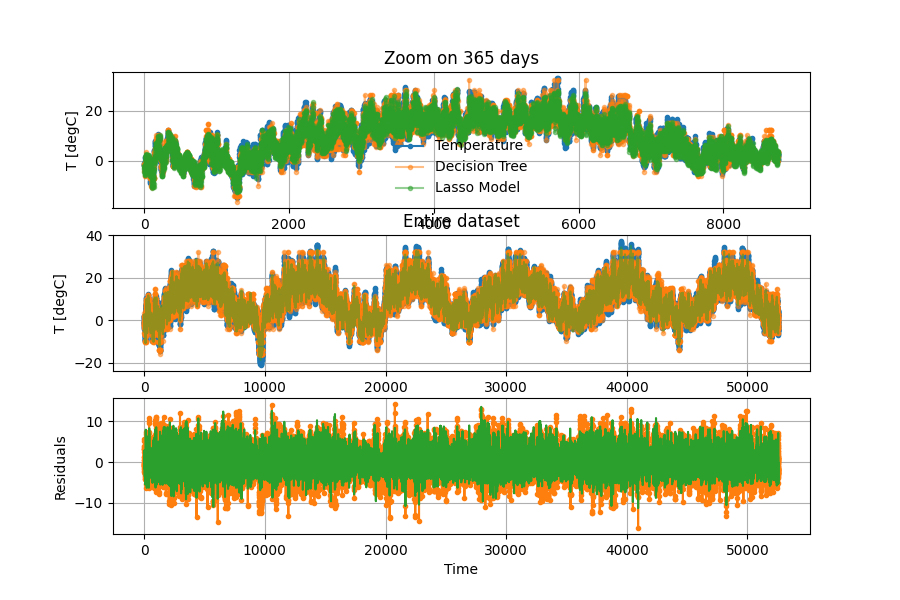

In [30]:
y_test_hat = dt_tuned_multi.predict(X_test)

def plot_multivariate(yhat, label, n_days=365):
    f, ax = plt.subplots(3,1,sharex=False, figsize=(9,6))
    ax[0].plot(y_test[0:24*n_days],'.-',label='Temperature')
    ax[0].plot(yhat[0:24*n_days], '.-',label=label, alpha = 0.5)
    ax[0].plot(y_lasso[0:24*n_days], '.-',label='Lasso Model', alpha = 0.5)
    ax[0].set_title('Zoom on {} days'.format(n_days))
    ax[0].legend(frameon=False)
    ax[1].plot(y_test,'.-',label='Temperature')
    ax[1].plot(yhat, '.-',label=label, alpha = 0.5)
    ax[1].plot(y_lasso,label='Lasso Model', alpha = 0.5)
    ax[1].set_title('Entire dataset')
    ax[2].plot(y_test - yhat, '.-',color='C1',label=label)
    ax[2].plot(y_test - y_lasso,color='C2',label='Lasso Model')
    ax[0].set_ylabel('T [degC]')
    ax[1].set_ylabel('T [degC]')
    ax[2].set_ylabel('Residuals')
    ax[2].set_xlabel('Time')
    ax[2]._shared_x_axes.join(ax[2],ax[1])
    for a in ax: a.grid(True);
plot_multivariate(y_test_hat, label='Decision Tree')
output_multi_metrics.loc['MAE','DecisionTree'] = mean_absolute_error(y_test, y_test_hat)
output_multi_metrics.loc['RMSE','DecisionTree'] = rmse(y_test, y_test_hat)

In [31]:
output_multi_metrics

,Persistence,Mean,Linear,Lasso,DecisionTree,RandomForest,XGBoost,SuperLearner
MAE,3.234641,3.768481,5.499938e+07,1.984893,2.034273,NaN,NaN,NaN
RMSE,4.289273,4.840742,2.542473e+09,2.566998,2.694454,NaN,NaN,NaN


### 4.1.2 Random Forest - DA FINIRE
As done for the univariate case, a Random Forest regressor with hyper-parameter tuning has been trained.

In [ ]:
force_retraining = True
gs = GridSearchCV(estimator=RandomForestRegressor(random_state=0), cv=TimeSeriesSplit(n_splits=n_splits), 
                  param_grid={
                      'n_estimators': [10, 50],
                      'criterion':['mae'],
                      'max_depth':[10, 100, 500],
                      'max_features': ['sqrt', 'log2'],
                      'min_samples_split': [10, 100, 500],
                      'ccp_alpha': [0,0.001]
                  },
                  scoring='neg_mean_absolute_error',
                  verbose=10, n_jobs=-1)
if force_retraining:
    gs.fit(X_train, y_train)
    joblib.dump(gs, 'models/Multivariate/RandomForest.pkl')
else:
    gs = joblib.load('models/Multivariate/RandomForest.pkl')
print('RandomForest - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('RandomForest - test MAE = {:.3f}'.format(mean_absolute_error(y_test, gs.best_estimator_.predict(X_test))))
print('RandomForest - test RMSE = {:.3f}'.format(rmse(y_test, gs.best_estimator_.predict(X_test))))
gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
gs_res.head(10)

spiega

In [ ]:
idx = 3
force_retraining = True
if force_retraining:
    rf_tuned_multi = RandomForestRegressor(random_state=0, n_jobs=-1)
    rf_tuned_multi.set_params(**gs_res.loc[idx,'params'])
    rf_tuned_multi.fit(X_train, y_train)
    joblib.dump(rf_tuned_multi, 'models/Multivariate/RandomForest_finalfit.pkl')
else:
    rf_tuned_multi = joblib.load('models/Multivariate/RandomForest_finalfit.pkl')
y_test_hat = rf_tuned_multi.predict(X_test)
plot_multivariate(y_test_hat, label='Random Forest')
output_multi_metrics.loc['MAE','RandomForest'] = mean_absolute_error(y_test, y_test_hat)
output_multi_metrics.loc['RMSE','RandomForest'] = rmse(y_test, y_test_hat)

In [ ]:
output_multi_metrics

### 4.1.3 Extreme Gradient Boosting (xgboost) - DA FINIRE
In the univariate case, the GradientBoosting algorithm from Scikit Learn has been used. In the multivariate case the Extreme Gradient Boosting algorithm is going to be used because of its proven performances in training time. <br>
The main parameters are the following:
- "n_estimator": number of estimator to be trained by the algorithm.
- "max_depth": maximum depth of the tree. This parameter controls the maximum depth of the tree to avoid overfitting.
- "learning_rate": the learning rate multiplier for each additional tree.
- "objective": scoring metric to be used. Here instead of MAE, MSE will be used.
- "booster": Specify which booster to use: gbtree, gblinear or dart.
- "tree_method": euristics to increase training speed.
- "subsample": the fraction of samples to be used for fitting the individual base learners.
- "colsample_bytree": the number of features to consider when looking for the best split (smiliar to "max_features")

In [ ]:
force_retraining = True
gs = GridSearchCV(estimator=xgb.XGBRegressor(random_state=0), cv=TimeSeriesSplit(n_splits=n_splits), 
                  param_grid={
                      'n_estimators': [10, 20],
                      'max_depth':[10,100],                      
                      'learning_rate': [0.000001, 0.0001, 0.01, 0.1],
                      'booster': ['dart','gbtree','gblinear'],
                      'tree_method': ['approx','hist','auto'],
                      'subsample':[0.5,0.75,1],
                      'colsample_bytree': [0.5, 0.75, 0.95],
                  },
                  scoring='neg_mean_absolute_error',
                  verbose=10, n_jobs=-1)
if force_retraining:
    gs.fit(X_train, y_train)
    joblib.dump(gs, 'models/Multivariate/XGBoost.pkl')
else:
    gs = joblib.load('models/Multivariate/XGBoost.pkl')
print('XGBoost - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('XGBoost - test MAE = {:.3f}'.format(mean_absolute_error(y_test, gs.best_estimator_.predict(X_test))))
print('XGBoost - test RMSE = {:.3f}'.format(rmse(y_test, gs.best_estimator_.predict(X_test))))
gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
gs_res.head(10)

spiega

In [ ]:
idx = 3
force_retraining = True
if force_retraining:
    xgb_tuned_multi = xgb.XGBRegressor(random_state=0, n_jobs=-1)
    xgb_tuned_multi.set_params(**gs_res.loc[idx,'params'])
    xgb_tuned_multi.fit(X_train, y_train)
    joblib.dump(xgb_tuned_multi, 'models/Multivariate/XGBoost_finalfit.pkl')
else:
    xgb_tuned_multi = joblib.load('models/Multivariate/XGBoost_finalfit.pkl')
y_test_hat = xgb_tuned_multi.predict(X_test)
plot_multivariate(y_test_hat, label='XGB')
output_multi_metrics.loc['MAE','XGBoost'] = mean_absolute_error(y_test, y_test_hat)
output_multi_metrics.loc['RMSE','XGBoost'] = rmse(y_test, y_test_hat)

In [ ]:
output_multi_metrics

### 4.1.4 SuperLearner - DA FINIRE

In [ ]:
force_retraining = True
reg1 = dt_tuned_multi
reg2 = rf_tuned_multi
reg3 = Lasso(alpha=0.1, max_iter=2000).fit(X_train, y_train)
reg4 = xgb_tuned_multi
ereg = VotingRegressor(estimators=[('dt', reg1), ('rf', reg2), ('lr', reg3), ('xgb', reg4)])
if force_retraining:
    ereg = ereg.fit(X_train, y_train)
    joblib.dump(ereg, 'models/Multivariate/SuperLearner.pkl')
else:
    ereg = joblib.load('models/Multivariate/SuperLearner.pkl')

y_test_hat = ereg.predict(testX)
plot_multivariate(y_test_hat, label='XGB')
output_multi_metrics.loc['MAE','SuperLearner'] = mean_absolute_error(y_test, y_test_hat)
output_multi_metrics.loc['RMSE','SuperLearner'] = rmse(y_test, y_test_hat)

In [ ]:
output_multi_metrics

# 5 - Conclusions

In [ ]:
# ############## Params START ##############
# n_in = 6 # Number of "previous data" to use as input
# n_ahead = 1 # Number of step ahead to predict
# single_output = True # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
# n_out = 1 if single_output else n_ahead # Number of outputs of the model
# train_size = 0.8 # Size of the training set
# n_splits = 5 # Number of splits for cross validation
# filename = 'sunspots.csv'
# ############## Params End ##############

# # load the dataset
# series = pd.read_csv(filename, header=0, index_col=0)

# # Transform the time series data into supervised learning
# data = series_to_supervised(series.values, n_in=n_in, n_out=n_ahead, single_output=single_output)
# data_train = data.values[0:int(train_size*data.shape[0])]
# data_test = data.values[int(train_size*data.shape[0]):]

# gs = GridSearchCV(estimator=model, cv=ts_splits, 
#                   param_grid={
#                       'criterion':['mae','mse'],
#                       'max_depth':[3],
#                       'min_samples_split': [5],
#                       'ccp_alpha': [0,1]                      
#                   },
#                   scoring='neg_mean_absolute_error')
# gs.fit(data_train[:, :-n_out], data_train[:, -n_out:])
# print('Decision Tree - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
# print('Decision Tree - test MAE = {:.3f}'.format(mean_absolute_error(testy, gs.best_estimator_.predict(testX))))
# gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
# gs_res.head(15)